In [1]:
#import librarys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow  as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *



from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import *
import os

In [2]:
#see if gpu is avaible
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#get data and filtere it 
frame = pd.read_csv(r'weekcount.csv')
df = pd.DataFrame(frame)
df.drop(df[df['year'] == 2020].index, inplace = True) #'REMOVE2020'
#df.drop(df[df['year'] == 2015].index, inplace = True) #remove 2015
#df.drop(df[df['year'] == 2019].index, inplace = True) #'REMOVE2020'
test = pd.DataFrame(df)
 
#reading and dumming datta
col = list(df.columns.values)

 



In [4]:
#get weather data
wframe = pd.read_csv(r'weather.csv')
weather = pd.DataFrame(wframe)
weather.head()

year  week  sunHour  totalSnow_cm  FeelsLikeC  cloudcover  humidity  \
0  2015    39    10.00           0.0       18.57       37.86     66.00   
1  2015    40     8.57           0.0       14.86       69.29     82.14   
2  2015    41     9.31           0.0       16.29       25.00     71.57   
3  2015    42     8.70           0.0       12.29       17.00     65.57   
4  2015    43     7.81           0.0       12.29       27.29     68.00   

   precipMM  tempC  windspeedKmph  
0      0.00  21.86          13.57  
1      4.73  18.14          22.43  
2      0.71  19.57          11.71  
3      0.07  16.29          15.71  
4      0.56  16.57          16.29

In [5]:
#merge both DF
df = pd.merge(df,weather,on=['year','week'],how='outer').dropna()
#df = df.reset_index()
print(df[df.index.duplicated()])
 
df

Empty DataFrame
Columns: [year, week, station, anzahl, sunHour, totalSnow_cm, FeelsLikeC, cloudcover, humidity, precipMM, tempC, windspeedKmph]
Index: []


year  week                station  anzahl  sunHour  totalSnow_cm  \
0      2015    39      5 Corners Library    43.0    10.00           0.0   
1      2015    39  Baldwin at Montgomery    66.0    10.00           0.0   
2      2015    39           Bayside Park    16.0    10.00           0.0   
3      2015    39           Brunswick St   186.0    10.00           0.0   
4      2015    39            Central Ave    25.0    10.00           0.0   
...     ...   ...                    ...     ...      ...           ...   
10464  2019    52               Union St    10.0     7.94           0.0   
10465  2019    52         Van Vorst Park    82.0     7.94           0.0   
10466  2019    52              Warren St   126.0     7.94           0.0   
10467  2019    52          Washington St   101.0     7.94           0.0   
10468  2019    52                York St    30.0     7.94           0.0   

       FeelsLikeC  cloudcover  humidity  precipMM  tempC  windspeedKmph  
0           18.57       37.86     66.00      0.00  21.86          13.57  
1           18.57       37.86     66.00      0.00  21.86          13.57  
2           18.57       37.86     66.00      0.00  21.86          13.57  
3           18.57       37.86     66.00      0.00  21.86          13.57  
4           18.57       37.86     66.00      0.00  21.86          13.57  
...           ...         ...       ...       ...    ...            ...  
10464        3.57       32.57     72.14      0.14   7.29           9.29  
10465        3.57       32.57     72.14      0.14   7.29           9.29  
10466        3.57       32.57     72.14      0.14   7.29           9.29  
10467        3.57       32.57     72.14      0.14   7.29           9.29  
10468        3.57       32.57     72.14      0.14   7.29           9.29  

[10469 rows x 12 columns]

In [6]:
#get input and output
x = df.drop("anzahl",axis=1)
y = df["anzahl"]

In [7]:
#split data into train and test
x_train, x_test ,y_train , y_test = train_test_split(x,y,test_size=0.2,shuffle=False)

In [8]:
#normalisie data
ct = make_column_transformer(
 (MinMaxScaler(),["year","week","sunHour", "totalSnow_cm", "FeelsLikeC", "cloudcover", "humidity", "precipMM", "tempC", "windspeedKmph"]),
     (OneHotEncoder(handle_unknown="ignore"),["station"])
 )

ct.fit(x_train)

x_train_normalized = ct.transform(x_train)

x_test_normalized = ct.transform(x_test)

x_train_normalized.shape

(8375, 73)

In [25]:
#load saved model if avaiable 
with tf.device('/device:CPU:0'):
    model = keras.models.load_model('Model2')

In [23]:
#create Model structure
with tf.device('/device:CPU:0'):
    model = Sequential()
    model.add(Dense(73, kernel_initializer='normal',  activation='relu', input_shape=(73,) ))
    model.add(Dropout(0.3))
    model.add(Dense(35, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(35, kernel_initializer='normal',activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(1, kernel_initializer='normal',activation=None))

In [24]:
#set model loss and optimizer
with tf.device('/device:CPU:0'):
    model.compile(optimizer= Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mape'])

In [28]:
#checkpoint to save best Model which isnt overfitted
checkpoint = ModelCheckpoint('Model2', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='min' )

In [25]:
#train Model
with tf.device('/device:CPU:0'):
    history = model.fit(x_train_normalized, y_train.values, epochs=1000 , batch_size=100,shuffle=False   )

Epoch 1/1000
84/84 [==============================] - 0s 2ms/step - loss: 111.9135 - mae: 111.9135 - mape: 99.9695
Epoch 2/1000
84/84 [==============================] - 0s 2ms/step - loss: 111.8693 - mae: 111.8693 - mape: 99.7103
Epoch 3/1000
84/84 [==============================] - 0s 2ms/step - loss: 111.6408 - mae: 111.6408 - mape: 98.3782
Epoch 4/1000
84/84 [==============================] - 0s 2ms/step - loss: 110.6277 - mae: 110.6277 - mape: 93.3770
Epoch 5/1000
84/84 [==============================] - 0s 2ms/step - loss: 107.6021 - mae: 107.6021 - mape: 89.8443
Epoch 6/1000
84/84 [==============================] - 0s 2ms/step - loss: 101.7313 - mae: 101.7313 - mape: 104.9192
Epoch 7/1000
84/84 [==============================] - 0s 2ms/step - loss: 93.2958 - mae: 93.2958 - mape: 148.2271
Epoch 8/1000
84/84 [==============================] - 0s 2ms/step - loss: 85.3624 - mae: 85.3624 - mape: 217.5476
Epoch 9/1000
84/84 [==============================] - 0s 2ms/step - loss: 80.7783

84/84 [==============================] - 0s 2ms/step - loss: 31.1904 - mae: 31.1904 - mape: 45.5434
Epoch 144/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.5853 - mae: 30.5853 - mape: 45.4999
Epoch 145/1000
84/84 [==============================] - 0s 2ms/step - loss: 31.3327 - mae: 31.3327 - mape: 45.8431
Epoch 146/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.6374 - mae: 30.6374 - mape: 45.0136
Epoch 147/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.7677 - mae: 30.7677 - mape: 46.2933
Epoch 148/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.2259 - mae: 30.2259 - mape: 44.5168
Epoch 149/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.5179 - mae: 30.5179 - mape: 44.9659
Epoch 150/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.3622 - mae: 30.3622 - mape: 44.6717
Epoch 151/1000
84/84 [==============================] - 0s 2ms/step - loss: 30.7292 - mae: 30.7

84/84 [==============================] - 0s 2ms/step - loss: 29.6967 - mae: 29.6967 - mape: 44.6385
Epoch 286/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.9451 - mae: 29.9451 - mape: 44.9681
Epoch 287/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.8095 - mae: 29.8095 - mape: 45.4174
Epoch 288/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.1882 - mae: 29.1882 - mape: 45.0499
Epoch 289/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.4691 - mae: 29.4691 - mape: 44.6382
Epoch 290/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.5244 - mae: 29.5244 - mape: 45.3806
Epoch 291/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.4714 - mae: 29.4714 - mape: 43.7203
Epoch 292/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.0333 - mae: 29.0333 - mape: 44.1875
Epoch 293/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.7427 - mae: 29.7

84/84 [==============================] - 0s 2ms/step - loss: 28.4811 - mae: 28.4811 - mape: 44.8666
Epoch 428/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.7155 - mae: 28.7155 - mape: 43.8680
Epoch 429/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.7069 - mae: 27.7069 - mape: 44.3280
Epoch 430/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.0547 - mae: 29.0547 - mape: 45.2242
Epoch 431/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.8285 - mae: 28.8285 - mape: 44.2356
Epoch 432/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.8119 - mae: 27.8119 - mape: 44.3992
Epoch 433/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.8095 - mae: 28.8095 - mape: 44.4790
Epoch 434/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.8254 - mae: 28.8254 - mape: 44.9603
Epoch 435/1000
84/84 [==============================] - 0s 2ms/step - loss: 29.0922 - mae: 29.0

84/84 [==============================] - 0s 2ms/step - loss: 27.6856 - mae: 27.6856 - mape: 44.3111
Epoch 570/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.0514 - mae: 28.0514 - mape: 43.5266
Epoch 571/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.6594 - mae: 27.6594 - mape: 44.4628
Epoch 572/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.6848 - mae: 28.6848 - mape: 45.0909
Epoch 573/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.6711 - mae: 27.6711 - mape: 44.6993
Epoch 574/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.1487 - mae: 28.1487 - mape: 43.2392
Epoch 575/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.9601 - mae: 27.9601 - mape: 43.4269
Epoch 576/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.0021 - mae: 28.0021 - mape: 45.4358
Epoch 577/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.8661 - mae: 27.8

84/84 [==============================] - 0s 2ms/step - loss: 27.2927 - mae: 27.2927 - mape: 44.3030
Epoch 712/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.9657 - mae: 26.9657 - mape: 43.5544
Epoch 713/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.9493 - mae: 26.9493 - mape: 43.7173
Epoch 714/1000
84/84 [==============================] - 0s 2ms/step - loss: 28.3986 - mae: 28.3986 - mape: 44.8455
Epoch 715/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.9839 - mae: 26.9839 - mape: 43.6855
Epoch 716/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.7553 - mae: 26.7553 - mape: 44.2995
Epoch 717/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.4891 - mae: 26.4891 - mape: 43.5416
Epoch 718/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.1758 - mae: 27.1758 - mape: 44.4293
Epoch 719/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.2827 - mae: 27.2

84/84 [==============================] - 0s 2ms/step - loss: 26.8155 - mae: 26.8155 - mape: 45.1395
Epoch 854/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.0227 - mae: 27.0227 - mape: 44.2592
Epoch 855/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.3997 - mae: 27.3997 - mape: 44.5532
Epoch 856/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.8539 - mae: 27.8539 - mape: 44.8979
Epoch 857/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.6918 - mae: 26.6918 - mape: 44.9299
Epoch 858/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.8022 - mae: 26.8022 - mape: 43.6126
Epoch 859/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.0448 - mae: 27.0448 - mape: 44.1244
Epoch 860/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.5542 - mae: 26.5542 - mape: 44.0129
Epoch 861/1000
84/84 [==============================] - 0s 2ms/step - loss: 27.4277 - mae: 27.4

84/84 [==============================] - 0s 2ms/step - loss: 26.1704 - mae: 26.1704 - mape: 43.3253
Epoch 996/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.2176 - mae: 26.2176 - mape: 45.1963
Epoch 997/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.7696 - mae: 26.7696 - mape: 44.4729
Epoch 998/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.7278 - mae: 26.7278 - mape: 43.9272
Epoch 999/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.4608 - mae: 26.4608 - mape: 43.4062
Epoch 1000/1000
84/84 [==============================] - 0s 2ms/step - loss: 26.6427 - mae: 26.6427 - mape: 44.4795


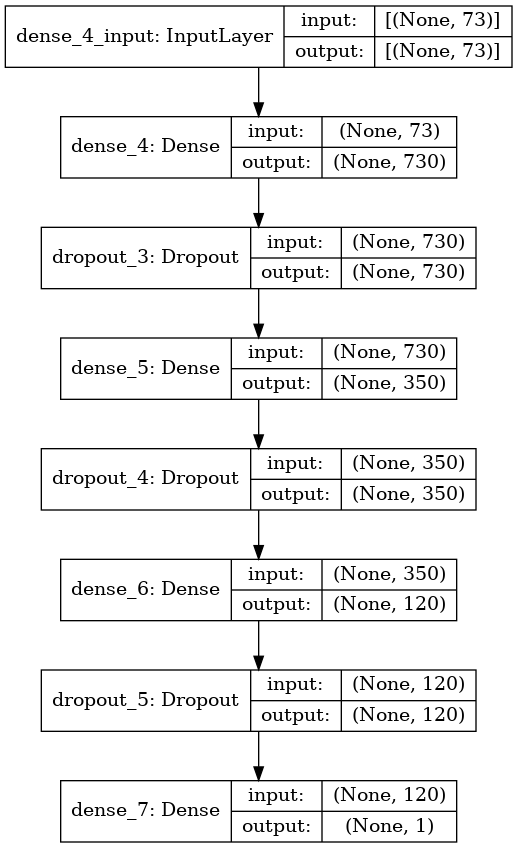

In [19]:
tf.keras.utils.plot_model(model,    show_shapes=True)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 730)               54020     
_________________________________________________________________
dropout_3 (Dropout)          (None, 730)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 350)               255850    
_________________________________________________________________
dropout_4 (Dropout)          (None, 350)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 120)               42120     
_________________________________________________________________
dropout_5 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [27]:
model.evaluate(x_test_normalized,y_test.values)

66/66 [==============================] - 1s 10ms/step - loss: 35.3100 - mae: 35.3100 - mape: 31.1545


[35.30998611450195, 35.30998611450195, 31.15454864501953]

In [15]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Anzahl]')
    plt.legend()
    plt.grid(True)

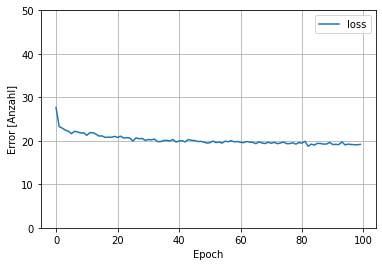

In [16]:
with tf.device('/device:CPU:0'):
    plot_loss(history)

In [23]:
stationnamesframe =   test.drop_duplicates() 
stationnamesframe = pd.DataFrame(stationnamesframe,columns=['station'])
stationnamesframe =   stationnamesframe.drop_duplicates() 
stationnames =  pd.DataFrame(stationnamesframe , columns=['station'])['station'].to_numpy().tolist()
print(stationnames)

['5 Corners Library', 'Baldwin at Montgomery', 'Bayside Park', 'Brunswick St', 'Central Ave', 'Christ Hospital', 'City Hall', 'Columbia Park', 'Dey St', 'Essex Light Rail', 'Exchange Place', 'Garfield Ave Station', 'Grove St PATH', 'Hamilton Park', 'Heights Elevator', 'Hilltop', 'JC Medical Center', 'Liberty Light Rail', 'Lincoln Park', 'MLK Light Rail', 'McGinley Square', 'NJCU', 'Newark Ave', 'Newport PATH', 'Newport Pkwy', 'North St', 'Oakland Ave', 'Paulus Hook', 'Pershing Field', 'Riverview Park', 'Sip Ave', 'Union St', 'Van Vorst Park', 'Warren St', 'West Side Light Rail', 'Jersey & 3rd', 'Jersey & 6th St', 'Lafayette Park', 'Morris Canal', 'Bethune Center', 'Columbus Drive', 'Danforth Light Rail', 'Dixon Mills', 'Leonard Gordon Park', 'Manila & 1st', 'Marin Light Rail', 'Monmouth and 6th', 'Astor Place', 'Brunswick & 6th', 'JCBS Depot', 'Communipaw & Berry Lane', 'York St', 'Harborside', 'Journal Square', 'Washington St', 'Bergen Ave', 'Fairmount Ave', 'Glenwood Ave', 'Grand St'

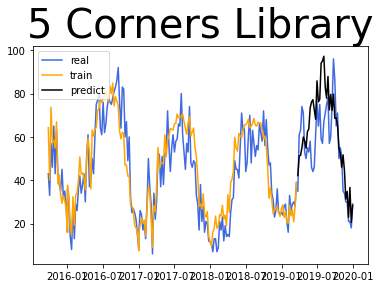

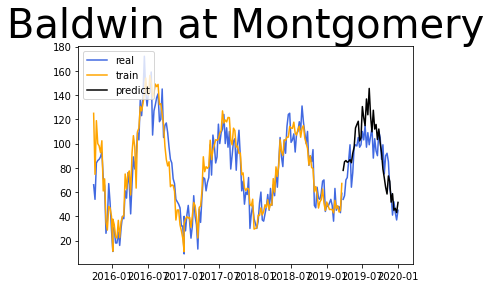

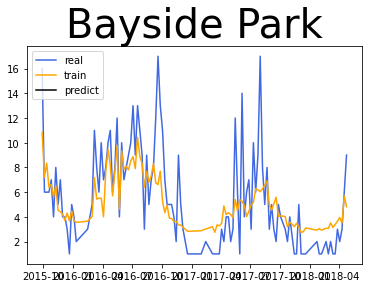

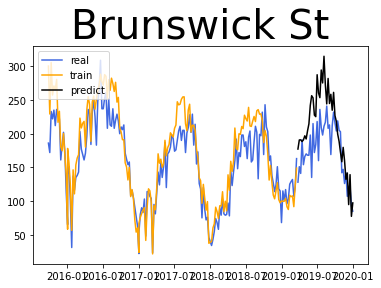

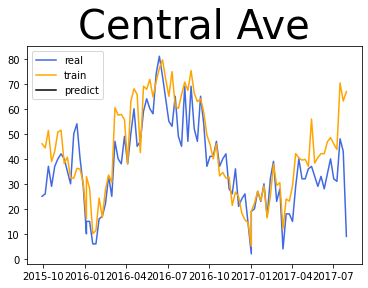

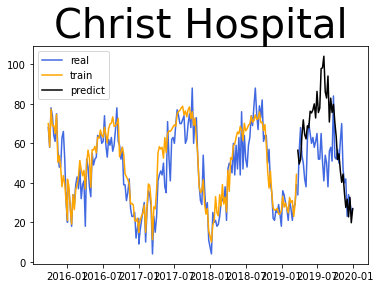

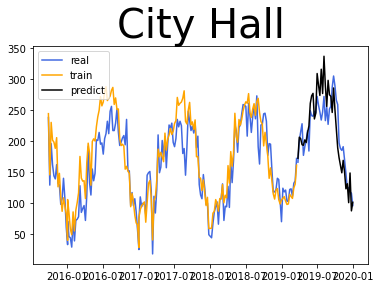

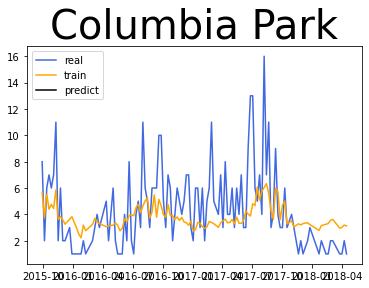

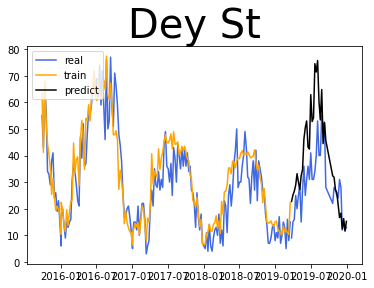

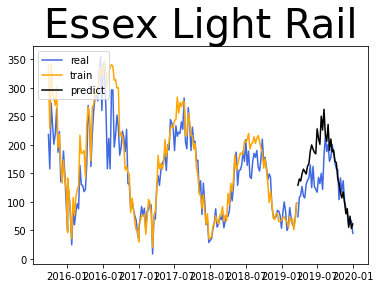

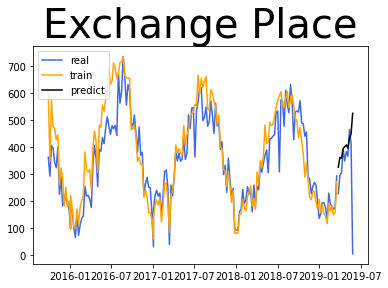

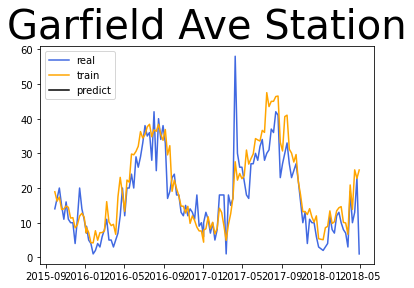

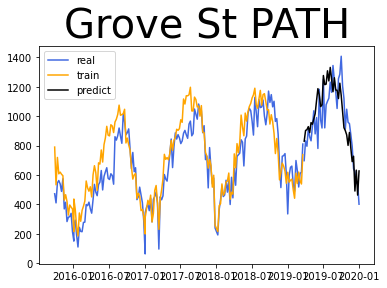

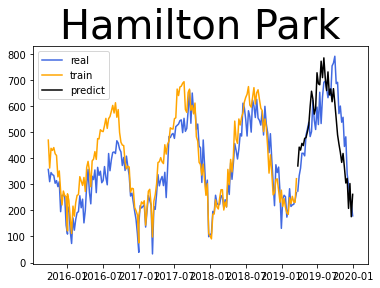

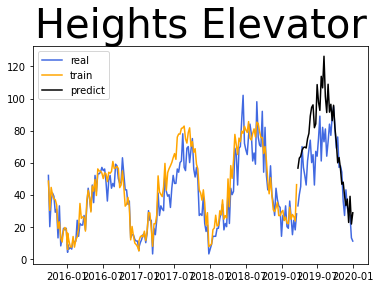

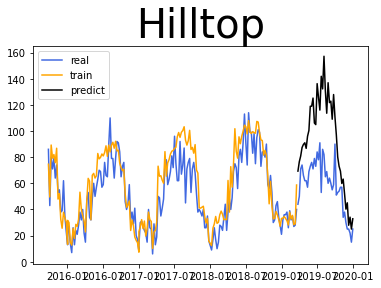

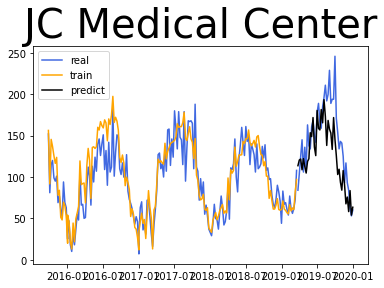

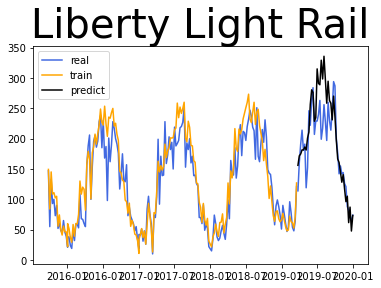

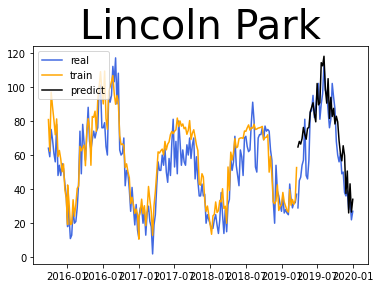

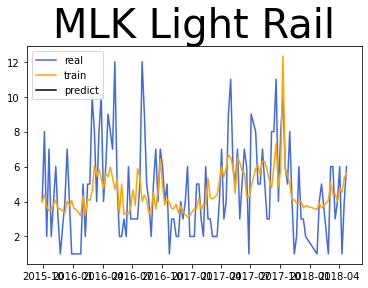

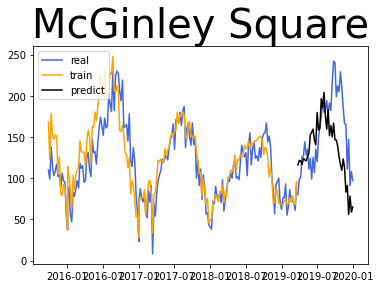

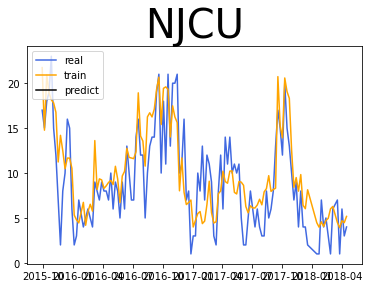

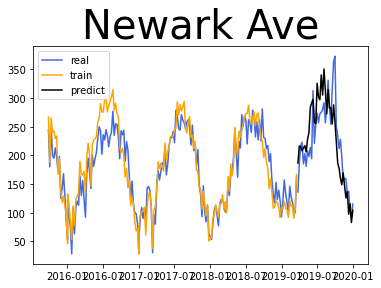

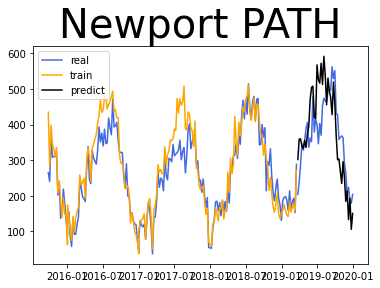

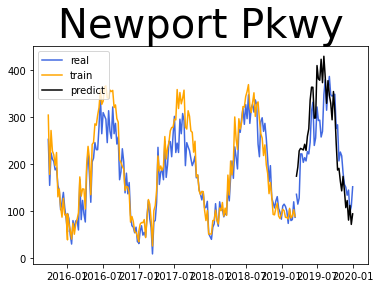

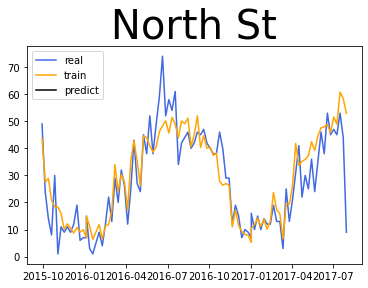

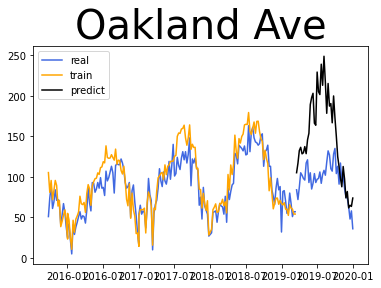

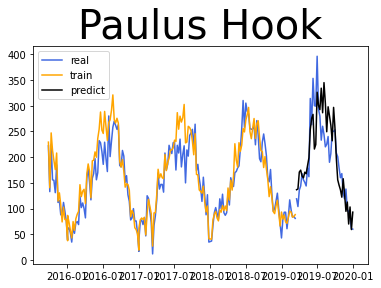

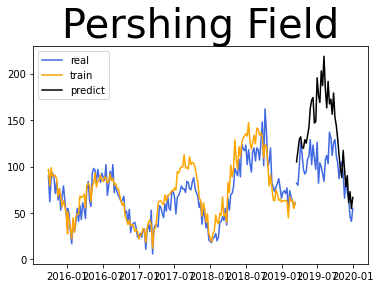

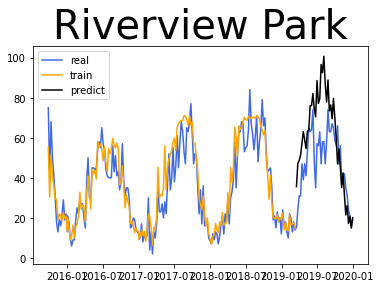

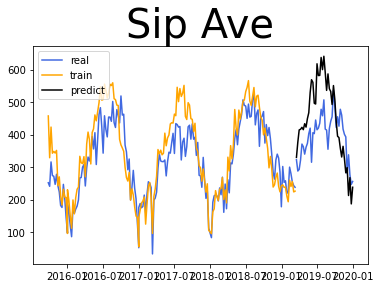

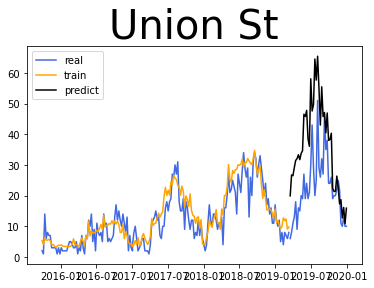

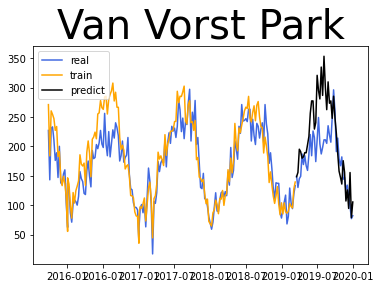

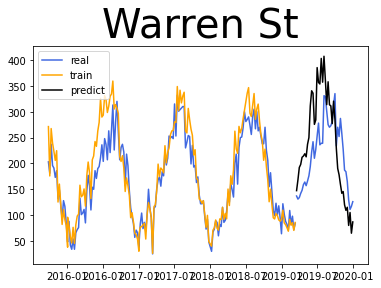

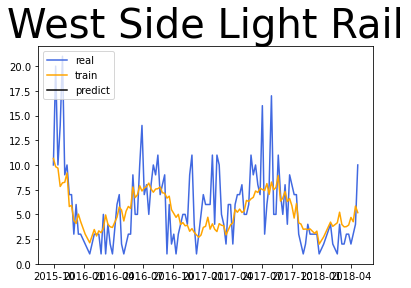

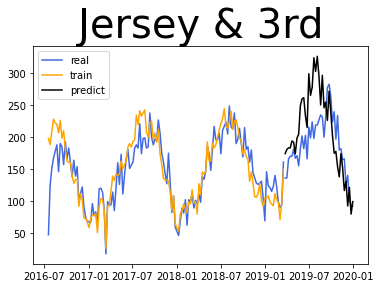

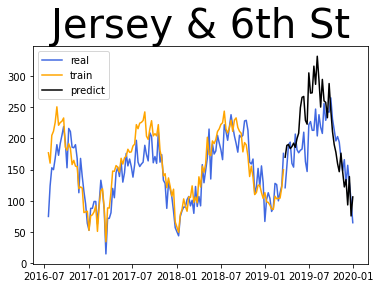

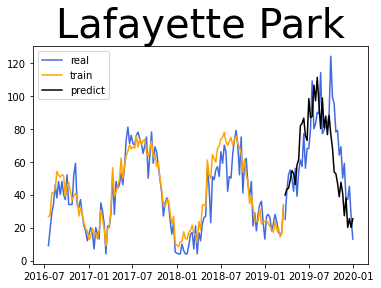

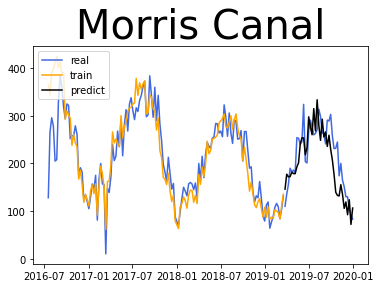

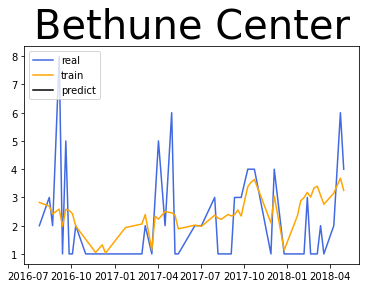

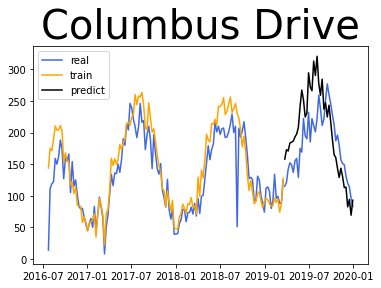

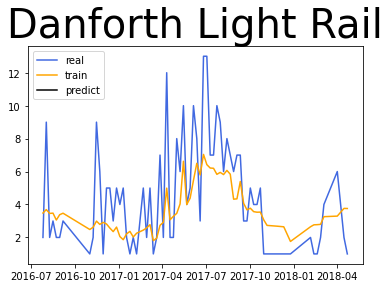

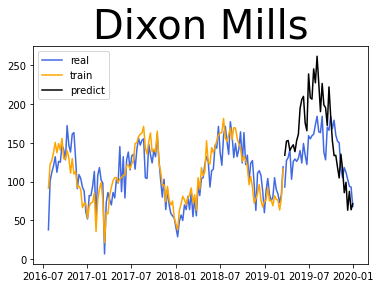

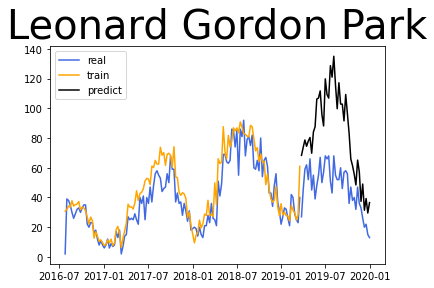

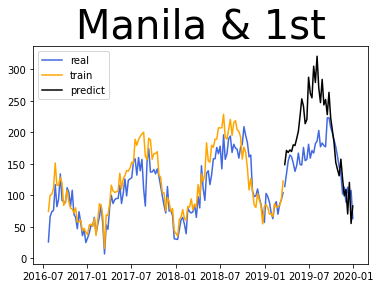

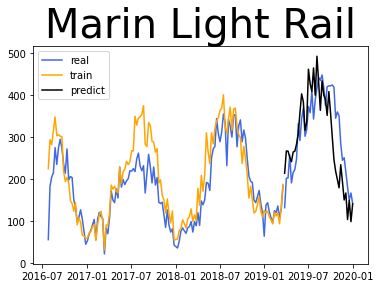

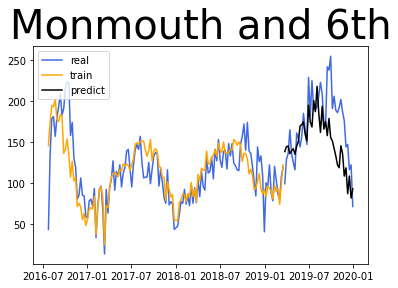

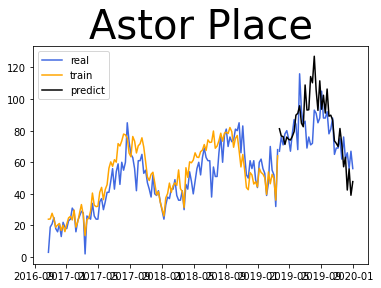

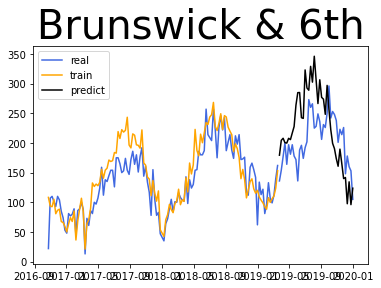

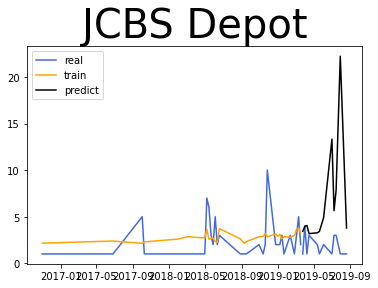

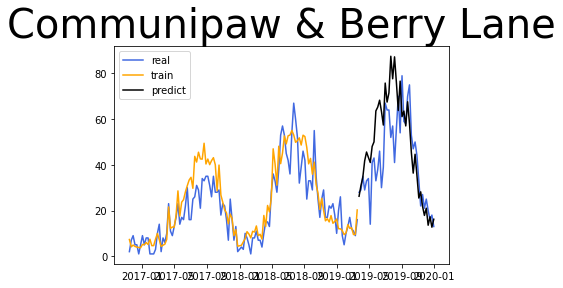

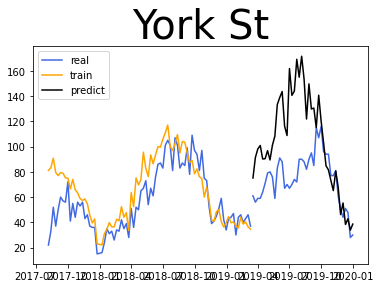

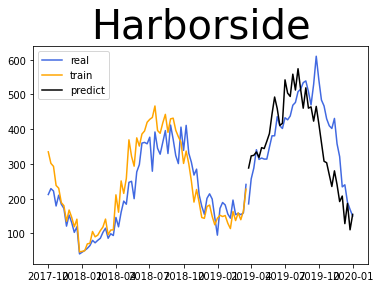

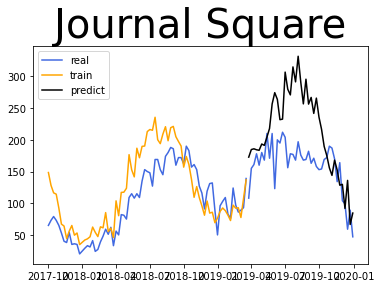

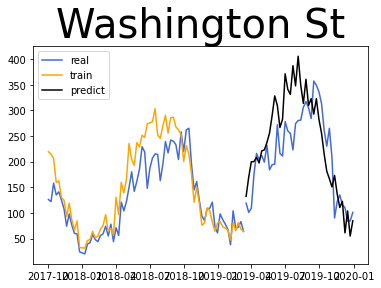

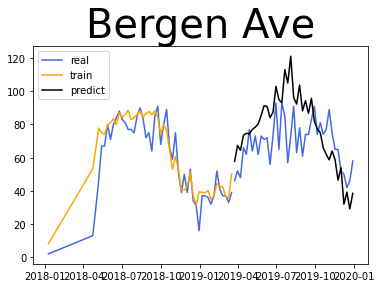

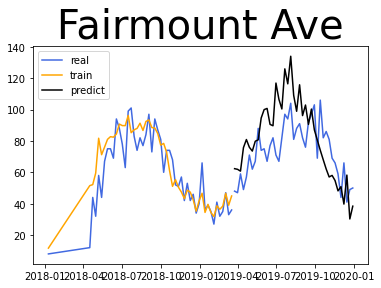

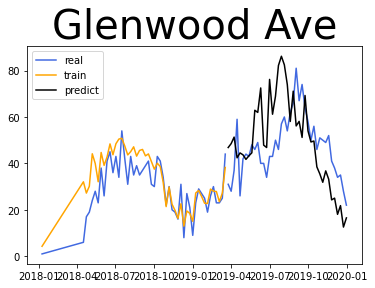

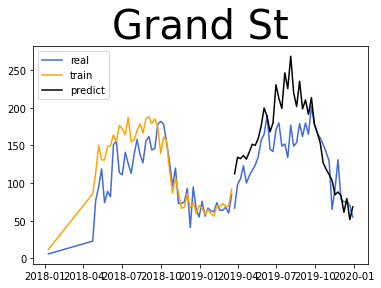

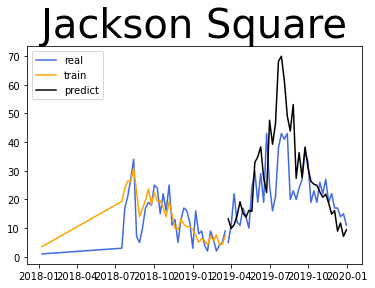

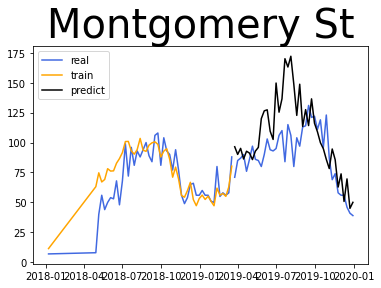

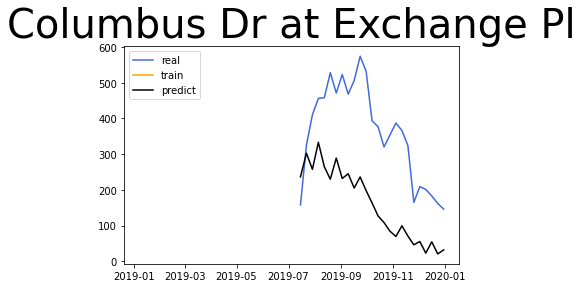

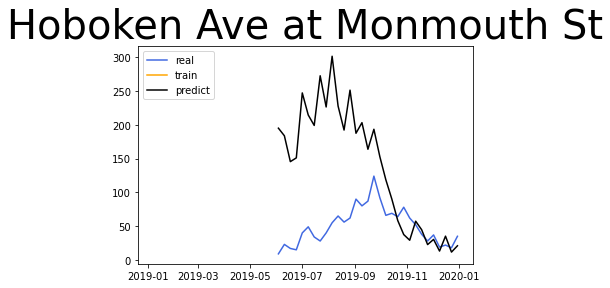

In [24]:
#show result data linear

for station in stationnames:
    predict_train = model.predict(x_train_normalized)
    y1 =  y_train 
    y2 =  predict_train 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#

    test1 = test.iloc[:y_train.shape[0]]
    test1 = pd.DataFrame(test1)
    test1['y'] = y1
    test1['y2'] = y2
    test1 = test1[test1['station']==station]
    test1['yearweek'] = pd.to_datetime(test1['year'].astype(str) + ' ' + test1['week'].astype(str) + ' 1',format='%Y %U %w')
    #print(test1)

    plt.plot(test1['yearweek'],test1['y'],label='real' , color = 'royalblue'  )
    plt.plot(test1['yearweek'],test1['y2'],label='train' , color = 'orange'  )
    predict_test = model.predict(x_test_normalized)
    y1 =  y_test 
    y2 =  predict_test 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#
    test2 = test.iloc[-y_test.shape[0]:]
    test2 = pd.DataFrame(test2)
    test2['y'] = y1
    test2['y2'] = y2
    test2 = test2[test2['station']==station]
    test2['yearweek'] = pd.to_datetime(test2['year'].astype(str) + ' ' + test2['week'].astype(str) + ' 1',format='%Y %U %w')
    #print(test2)
    try:
        mae = mean_absolute_error(test2['y'] ,test2['y2'] )
        plt.title(label=station+", mae: {:0.2f}".format(mae) ,
          fontsize=40,
          color="black")
    except:
        plt.title(label=station+", mae: nan"  ,
          fontsize=40,
          color="black")
    plt.plot(test2['yearweek'],test2['y'],label='_Hidden' , color = 'royalblue'  )
    plt.plot(test2['yearweek'],test2['y2'],label='predict' , color = 'black' )
    
    plt.legend(loc="upper left")
    plt.savefig( 'Model2Images/'+station+'linear.jpg',bbox_inches='tight', dpi=150)
    plt.show()
 

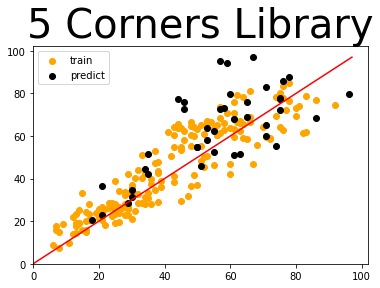

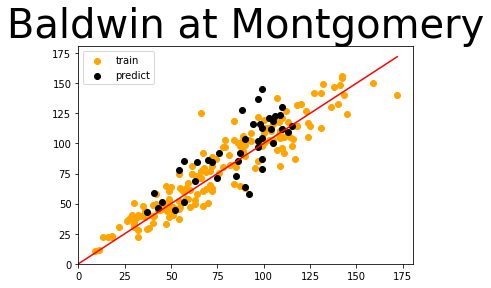

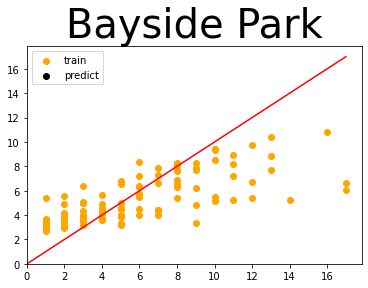

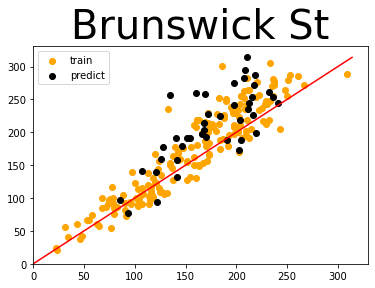

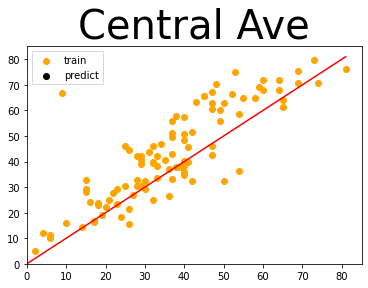

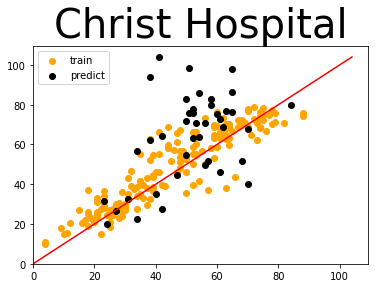

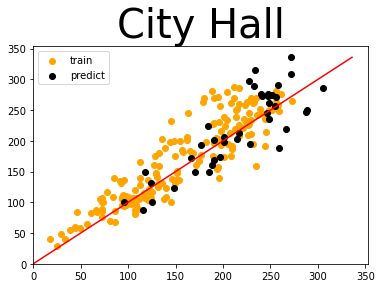

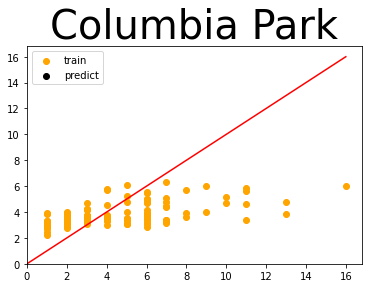

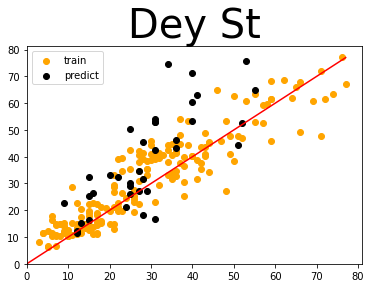

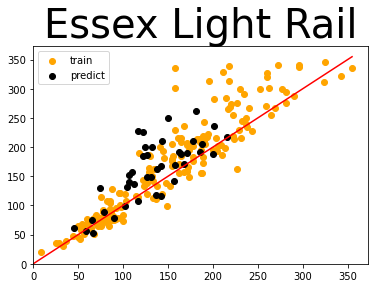

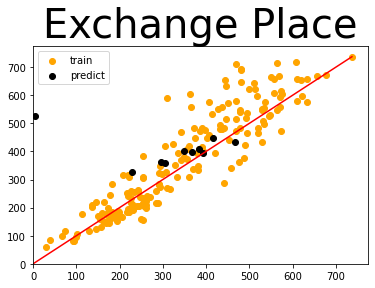

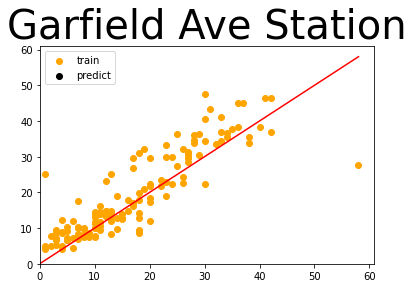

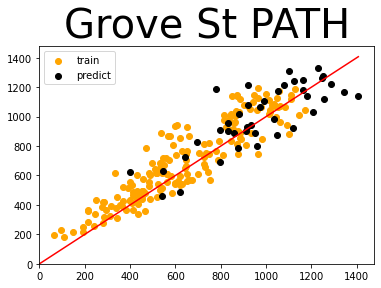

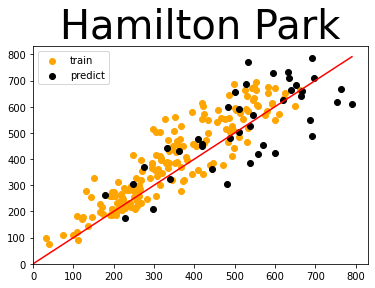

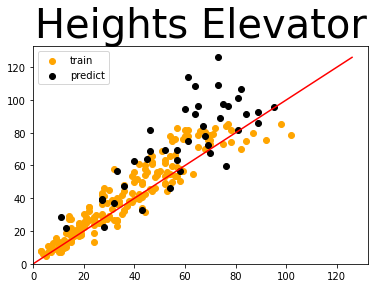

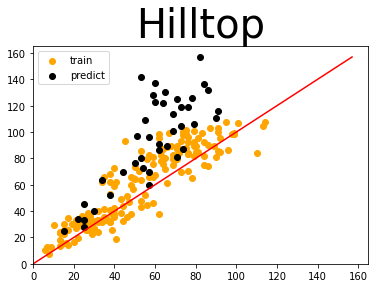

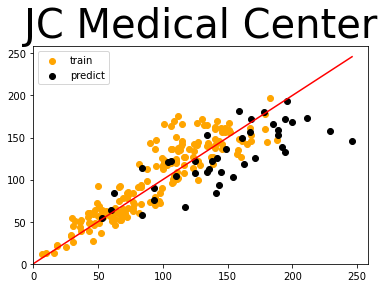

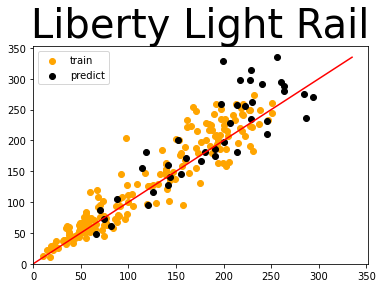

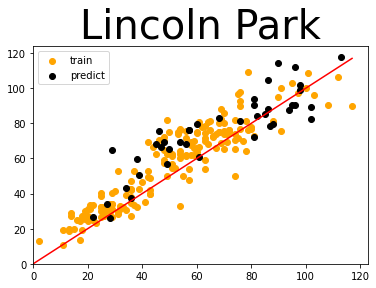

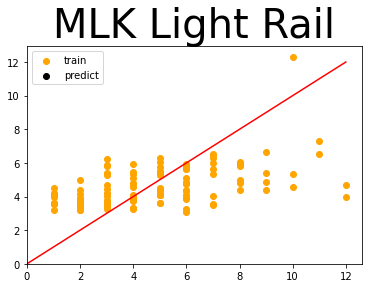

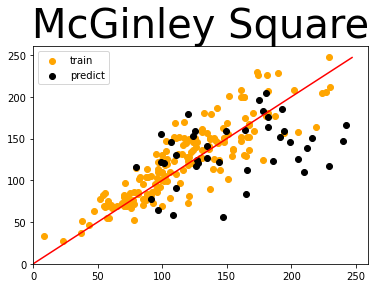

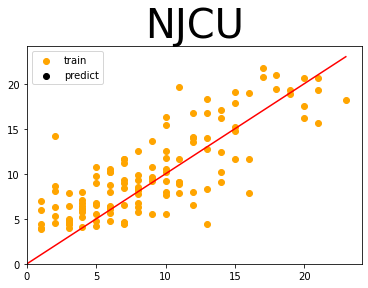

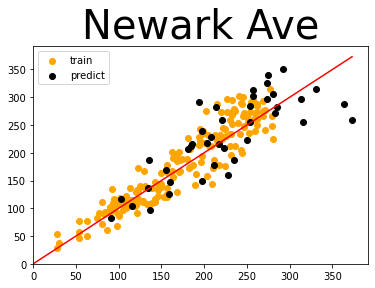

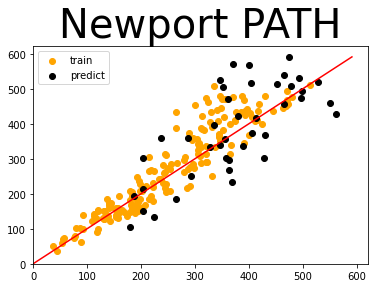

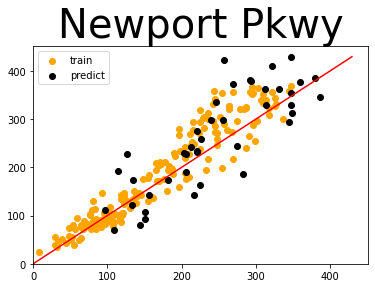

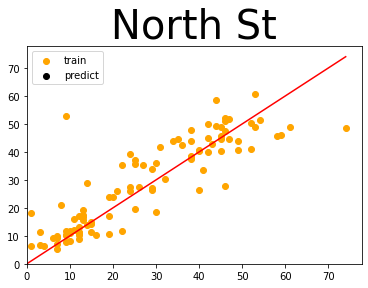

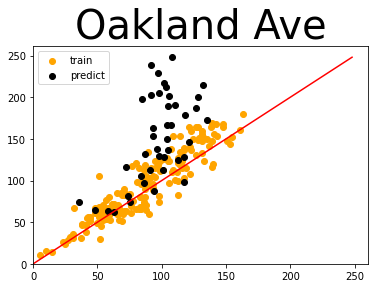

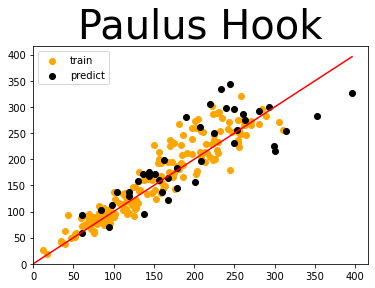

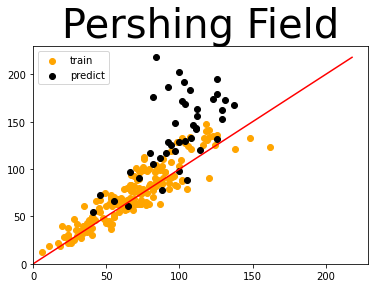

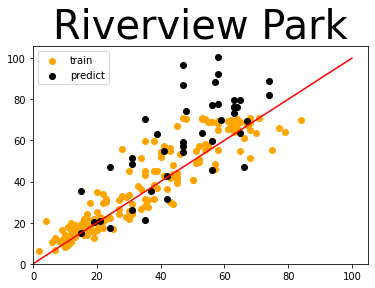

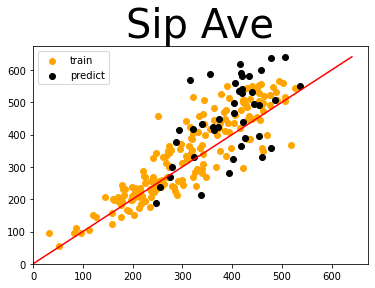

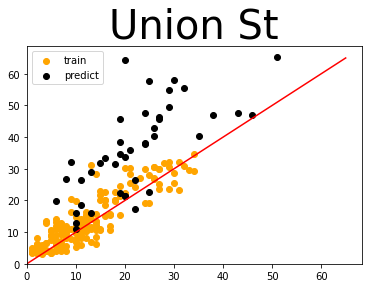

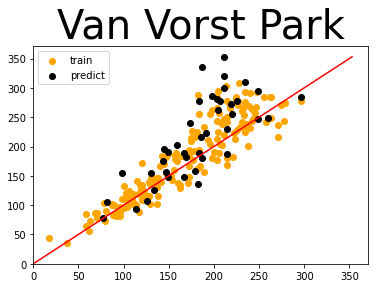

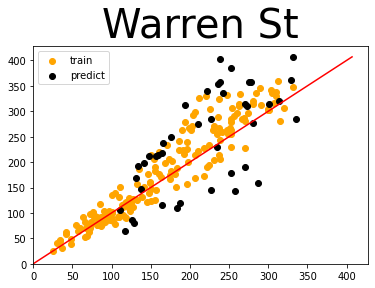

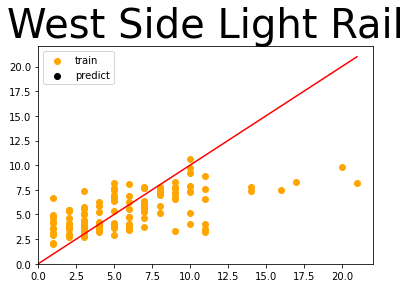

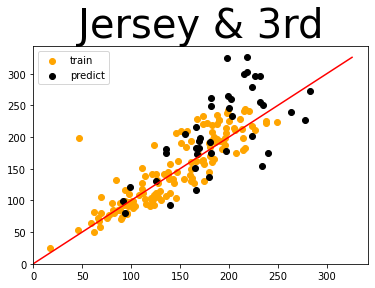

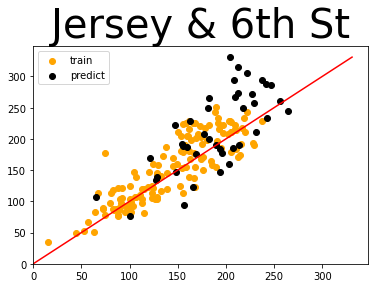

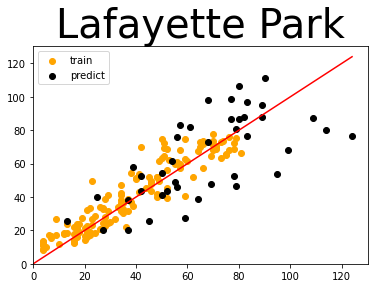

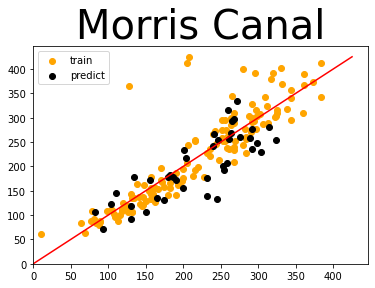

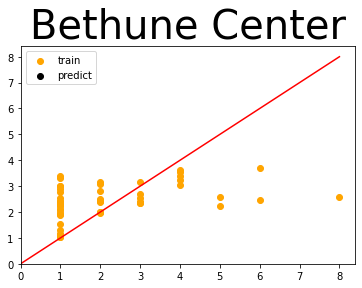

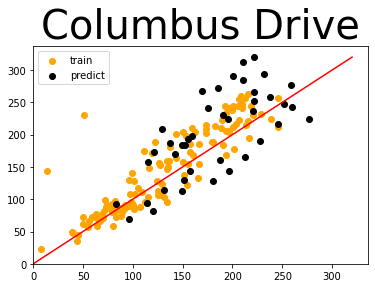

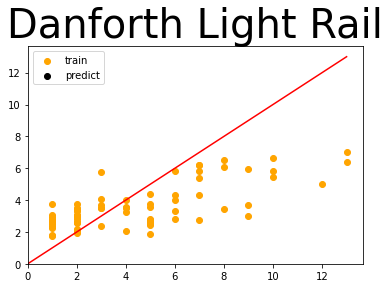

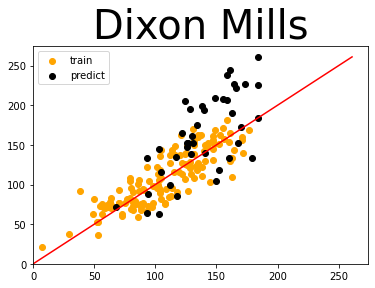

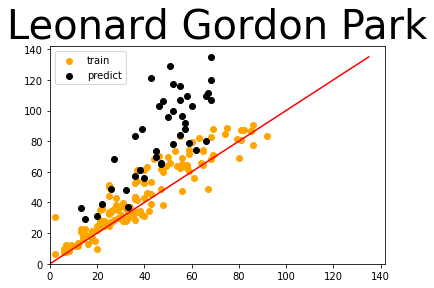

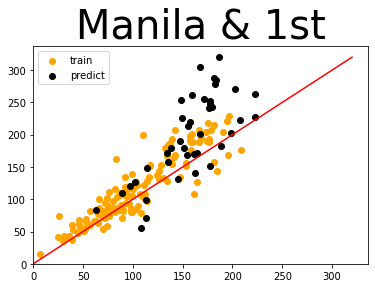

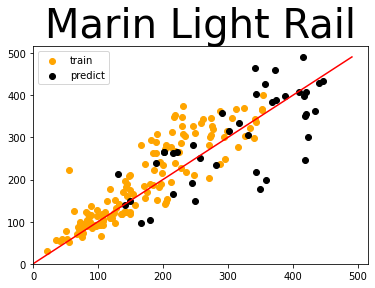

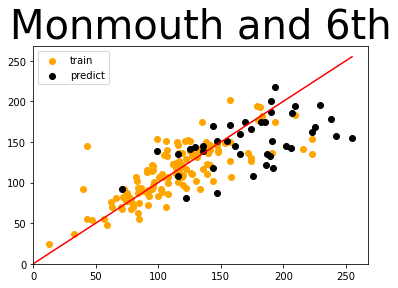

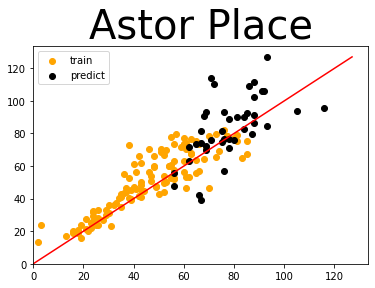

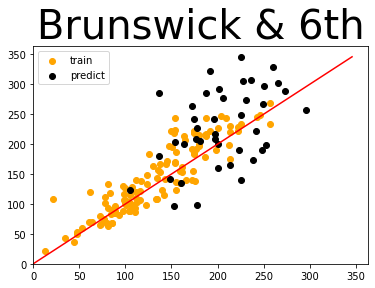

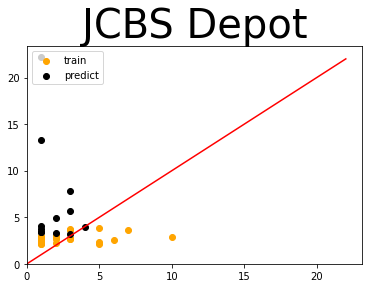

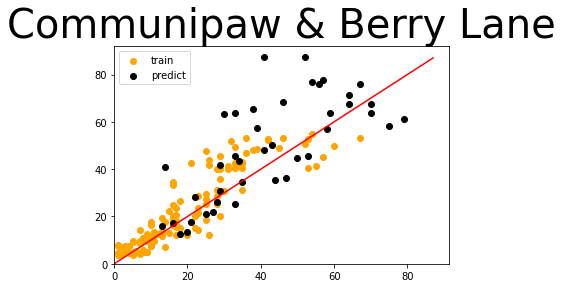

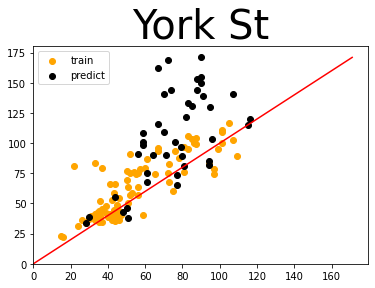

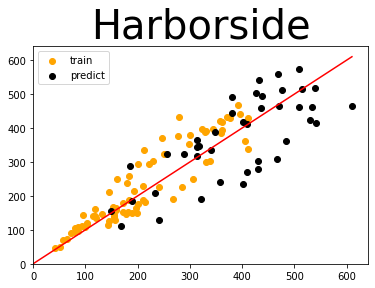

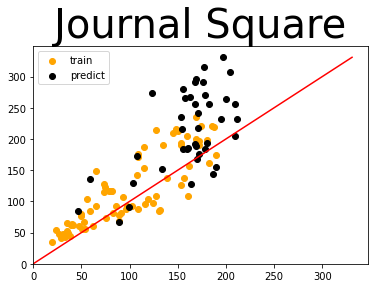

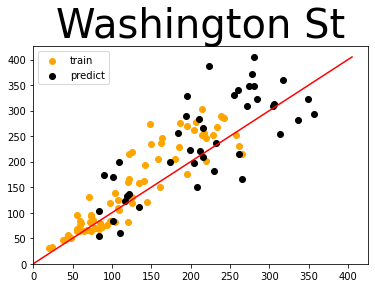

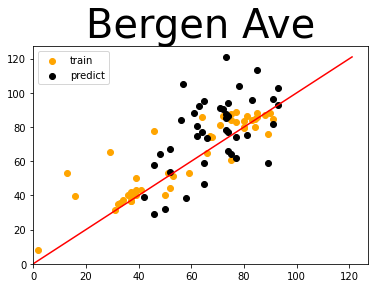

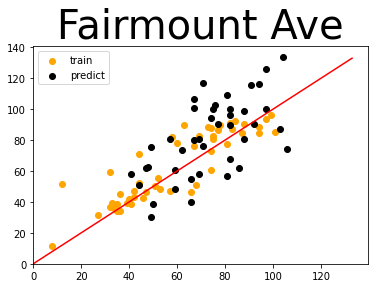

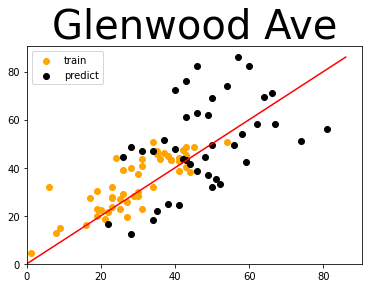

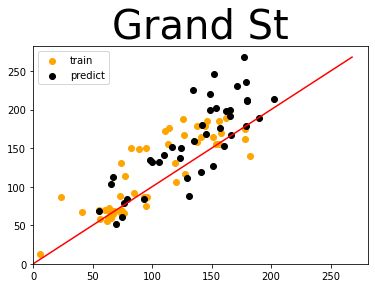

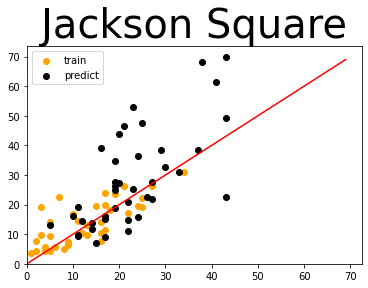

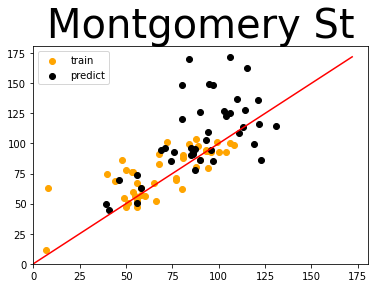

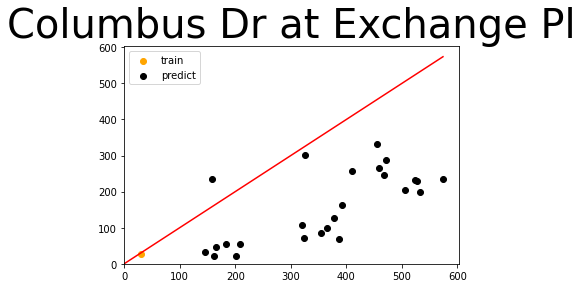

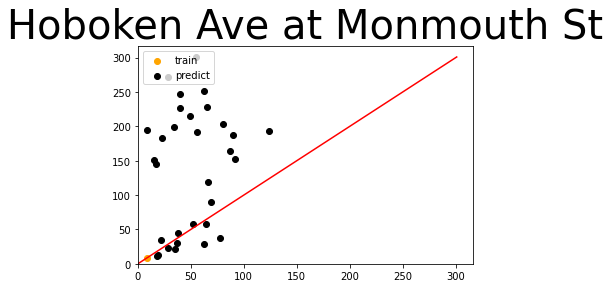

In [25]:
#show result data scatter

for station in stationnames:

    predict_train = model.predict(x_train_normalized)
    y1 =  y_train 
    y2 = predict_train 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#
    
    test1 = test.iloc[:y_train.shape[0]]
    test1 = pd.DataFrame(test1)
    test1['y'] = y1
    test1['y2'] = y2
    test1 = test1[test1['station']==station]
    test1['yearweek'] = pd.to_datetime(test1['year'].astype(str) + ' ' + test1['week'].astype(str) + ' 1',format='%Y %U %w')
    #print(test1)
     
   
    plt.scatter(test1['y'],test1['y2'],label='train' , color = 'orange'  )
    predict_test = model.predict(x_test_normalized)
    y1 =  y_test 
    y2 =  predict_test 
    #test = pd.DataFrame({ 'y':y1 ,'y2':y2})#
    test2 = test.iloc[-y_test.shape[0]:]
    test2 = pd.DataFrame(test2)
    test2['y'] = y1
    test2['y2'] = y2
    test2 = test2[test2['station']==station]
    test2['yearweek'] = pd.to_datetime(test2['year'].astype(str) + ' ' + test2['week'].astype(str) + ' 1',format='%Y %U %w')
    plt.scatter(test2['y'],test2['y2'],label='predict' , color = 'black' )
    #print(test2)
    maxdata1 = (test1['y'].max())if(test1['y'].max() > test1['y2'].max()) else test1['y2'].max()
    maxdata1 = int(maxdata1)
    maxdata2 = (test2['y'].max())if(test2['y'].max() > test2['y2'].max()) else test2['y2'].max()
    maxdata2 = int( 0 if(np.isnan(maxdata2)) else maxdata2)
    maxdata = (maxdata1)if(maxdata1 > maxdata2) else maxdata2
    maxdata = int(maxdata)
    
    try:
        mae = mean_absolute_error(test2['y'] ,test2['y2'] )
        plt.title(label=station+", mae: {:0.2f}".format(mae) ,
          fontsize=40,
          color="black")
    except:
        plt.title(label=station+", mae: nan"  ,
          fontsize=40,
          color="black")
    xline =   np.linspace(0,maxdata,maxdata)
    plt.plot([0,maxdata],[0,maxdata] , color='red')
    plt.ylim(bottom=0)
    plt.xlim(xmin=0)
    plt.legend(loc="upper left")
    plt.savefig( 'Model2Images/'+station+'scatter.jpg',bbox_inches='tight', dpi=150)
    plt.show()

In [10]:
with tf.device('/device:GPU:0'):
    results = model.evaluate(x_test, y_test )
print("Result", results)

66/66 [==============================] - 1s 7ms/step - loss: 0.0013 - mae: 0.0221 - mape: 32742.9414
Result [0.00133007753174752, 0.022127656266093254, 32742.94140625]
